<a href="https://colab.research.google.com/github/mlily2024/mlily2024/blob/main/BERT_GNN_with_sensitivity_analysis_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HYBRID BERT AND GRAPH NEURAL NETWORKS IN SQL INJECTION DETECTION

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install torch_geometric

In [ ]:
!pip install optuna

In [ ]:
# Loading and importing Libraries
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import optuna
import time
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split, KFold
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, BertModel
from torch_geometric.data import Data, Batch
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from torch_geometric.loader import DataLoader
import sys
from torch_geometric.utils import subgraph


# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Upload and load the dataset
from google.colab import files
upload = files.upload()

Saving SQL_Injection_Dataset.csv to SQL_Injection_Dataset (1).csv


Loading dataset and Exploratory Data Analysis

In [ ]:
# Load and displaying dataset
df = pd.read_csv('SQL_Injection_Dataset.csv')
df.head(10)

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
5,select name from syscolumns where id = ...,1
6,select * from users where id = 1 +$+ or 1 =...,1
7,"1; ( load_file ( char ( 47,101,116,99,47...",1
8,select * from users where id = '1' or ||/1 ...,1
9,select * from users where id = '1' or \.<\ ...,1


In [ ]:
# Dataset dimension
df.shape

(30919, 2)

In [ ]:
# data types of the  features
print(df.dtypes)


Query    object
Label     int64
dtype: object


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   30919 non-null  object
 1   Label   30919 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 483.2+ KB


In [ ]:
# Data preprocessing
df['Query'] = df['Query'].apply(lambda x: x.lower().strip())
df['Query_Length'] = df['Query'].apply(lambda x: len(x.split()))

# Determine the 99th percentile for query length
query_length_threshold = df['Query_Length'].quantile(0.99)
print(f"99th percentile of query length: {query_length_threshold}")

# Retain all data points, including outliers
df_no_outliers = df  # No outlier removal for now

# Drop the Query_Length column as it's no longer needed
df_no_outliers = df_no_outliers.drop(columns='Query_Length')

# Display basic information about the dataset
print(df_no_outliers.info())
print(df_no_outliers.describe())

# Check for missing values
missing_values = df_no_outliers.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Analyze class distribution
class_distribution = df_no_outliers['Label'].value_counts(normalize=True)
print("Class distribution:\n", class_distribution)


99th percentile of query length: 79.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   30919 non-null  object
 1   Label   30919 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 483.2+ KB
None
              Label
count  30919.000000
mean       0.368123
std        0.482303
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Missing values in each column:
 Query    0
Label    0
dtype: int64
Class distribution:
 Label
0    0.631877
1    0.368123
Name: proportion, dtype: float64


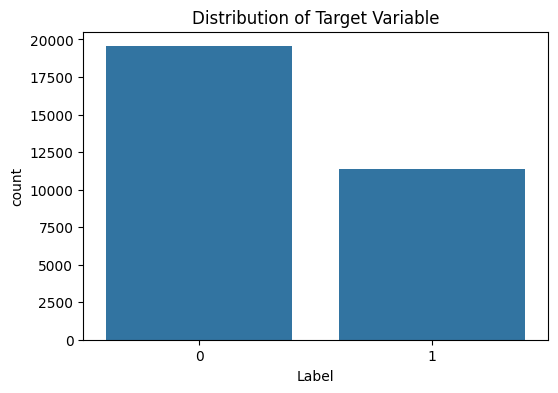

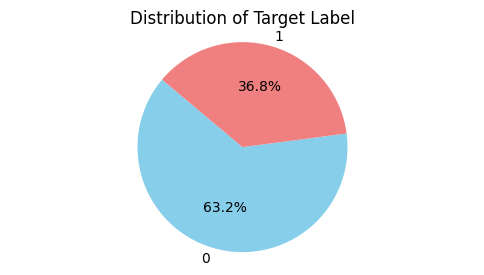

In [ ]:
# Plot distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=df)
plt.title('Distribution of Target Variable')
plt.show()

# Count the occurrences of each label
label_counts = df['Label'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(6, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Target Label')
plt.axis('equal')
plt.show()


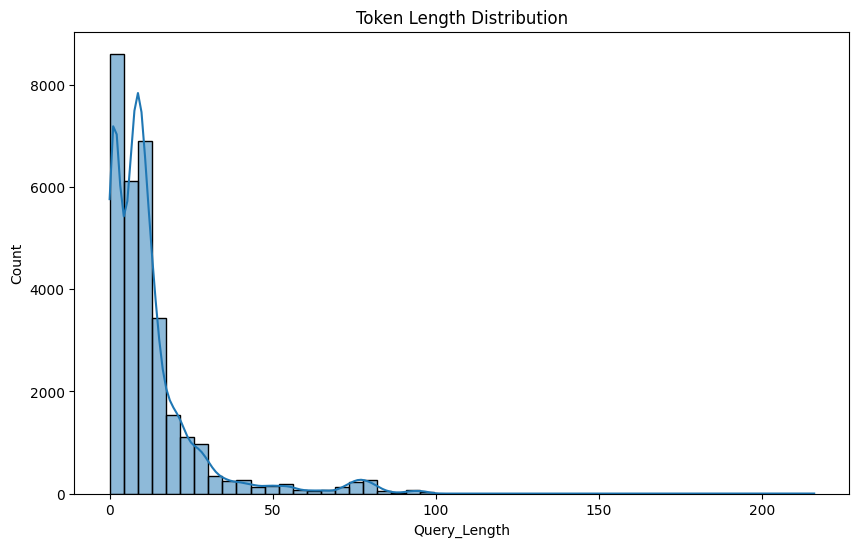

In [ ]:
# Plot token length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Query_Length'], bins=50, kde=True)
plt.title('Token Length Distribution')
plt.show()

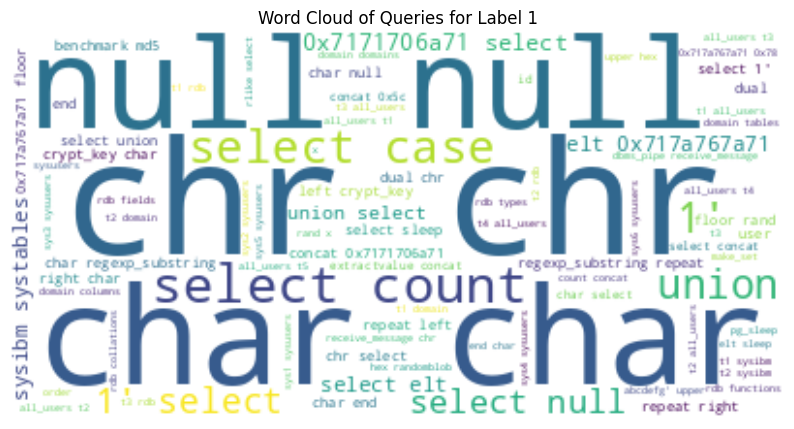

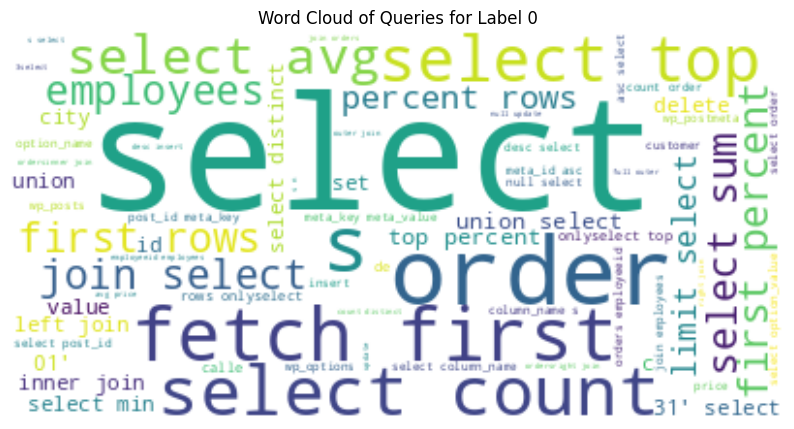

In [ ]:
# Generate word clouds for each label
for label in df['Label'].unique():
    text = " ".join(query for query in df[df['Label'] == label]['Query'])
    wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud of Queries for Label {label}")
    plt.show()

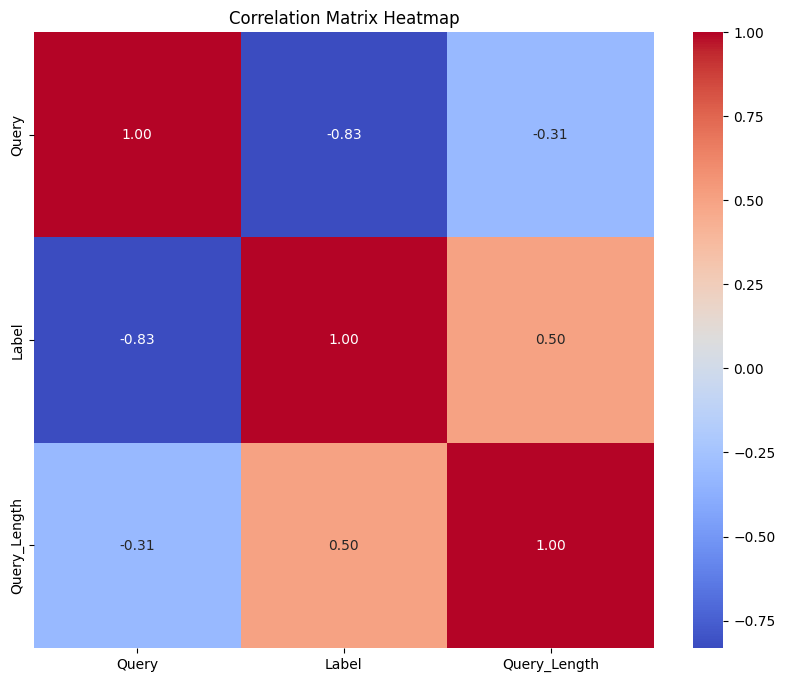

In [ ]:
# Encode categorical features for correlation analysis
df_encoded = df.copy()
df_encoded['Query'] = df_encoded['Query'].factorize()[0]

# Compute the correlation matrix
corr_matrix = df_encoded.corr()

# Generate a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


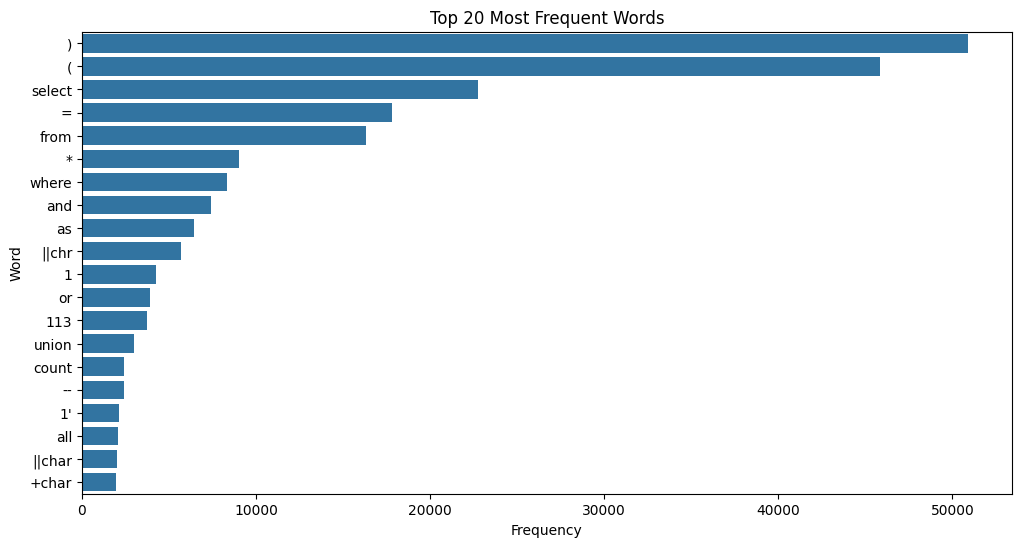

In [ ]:
# Split each Query into words and create a list of all words
words = [word for query in df['Query'] for word in query.split()]

# Count the frequency of each word
word_counts = Counter(words)

# Create a dataframe for the word frequencies
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the word frequencies
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=word_freq_df.head(20))
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

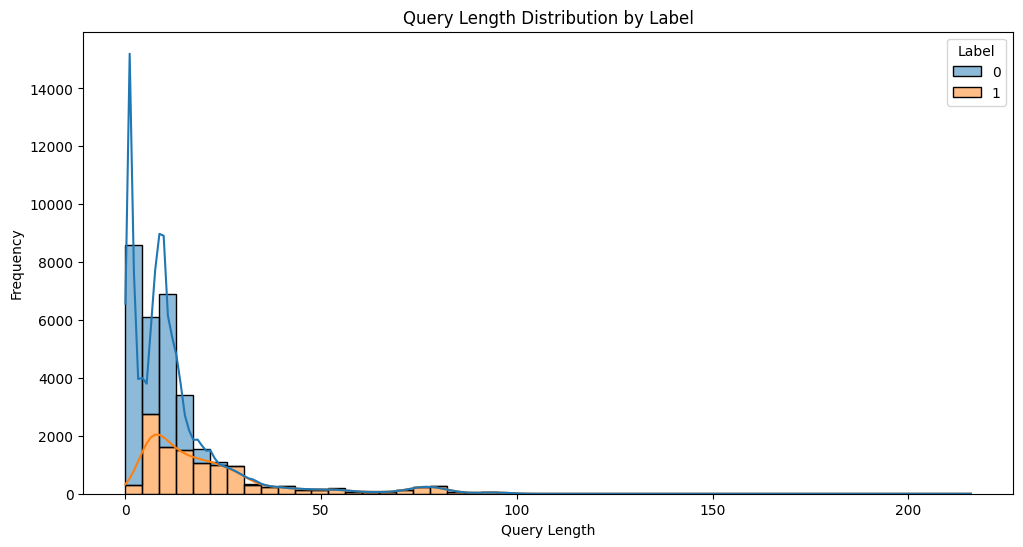

In [ ]:
# Visualizing Query Length Distribution by Label
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Query_Length', hue='Label', multiple='stack', bins=50, kde=True)
plt.title('Query Length Distribution by Label')
plt.xlabel('Query Length')
plt.ylabel('Frequency')
plt.show()

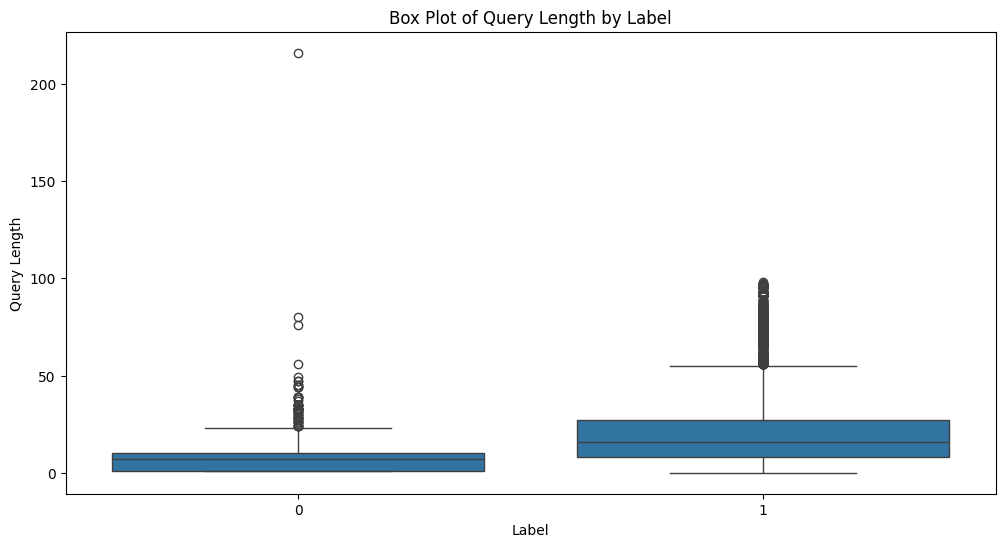

In [ ]:
# Box plots for query length by label
plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='Query_Length', data=df)
plt.title('Box Plot of Query Length by Label')
plt.xlabel('Label')
plt.ylabel('Query Length')
plt.show()

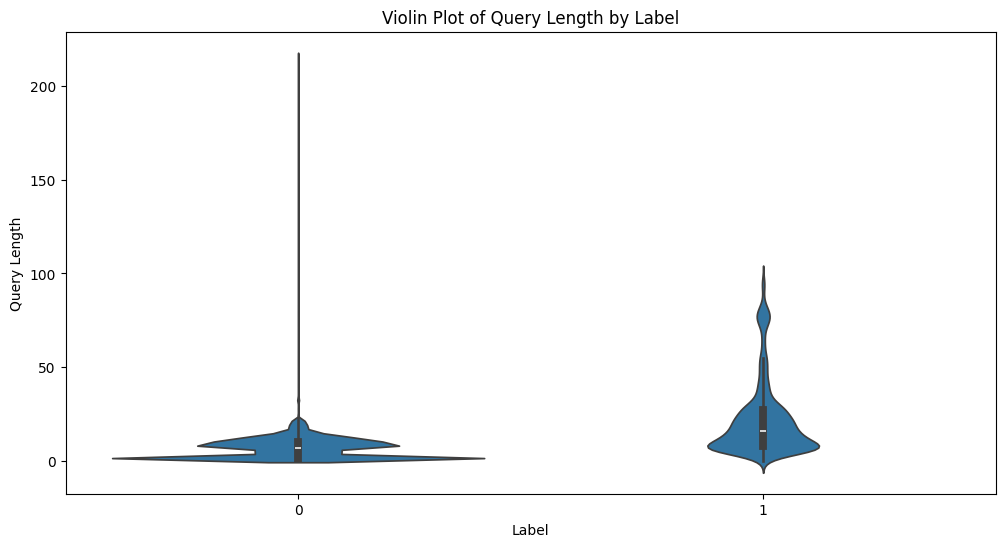

In [ ]:
# Violin plots for query length by label
plt.figure(figsize=(12, 6))
sns.violinplot(x='Label', y='Query_Length', data=df)
plt.title('Violin Plot of Query Length by Label')
plt.xlabel('Label')
plt.ylabel('Query Length')
plt.show()

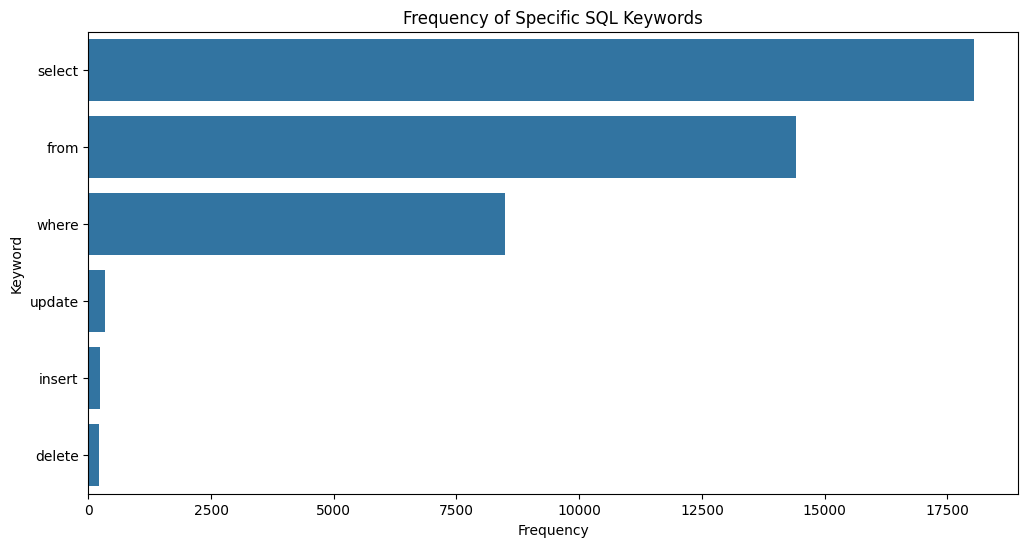

In [ ]:
# Frequency of specific SQL keywords
keywords = ['select', 'from', 'where', 'insert', 'update', 'delete']
keyword_counts = {keyword: df['Query'].str.contains(keyword, case=False).sum() for keyword in keywords}

# Create a dataframe for keyword frequencies
keyword_freq_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the keyword frequencies
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Keyword', data=keyword_freq_df)
plt.title('Frequency of Specific SQL Keywords')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

In [ ]:
# Class distribution
class_distribution = df['Label'].value_counts(normalize=True)
average_query_length = df['Query_Length'].mean()

# Summary and insights from the EDA
print("Summary and Insights:")
print(f"1. The dataset contains {df.shape[0]} samples and {df.shape[1]} features after filtering for binary classification.")
print(f"2. The target variable is imbalanced with the following distribution:\n{class_distribution}")
print(f"3. The average query length is {average_query_length:.2f} words.")
print(f"4. No missing values were found in the 'Query' and 'Label' columns after preprocessing.")
print(f"5. The distribution of 'Query_Length' shows that there is a variation in the length of queries, which could be indicative of different types of queries.")
print("6. The word cloud visualization indicates that common SQL keywords such as 'select', 'from', and 'where' are frequently used in the queries.")
print("7. Correlation analysis did not reveal strong linear relationships between features, which is expected given the nature of text data.")


Summary and Insights:
1. The dataset contains 30919 samples and 3 features after filtering for binary classification.
2. The target variable is imbalanced with the following distribution:
Label
0    0.631877
1    0.368123
Name: proportion, dtype: float64
3. The average query length is 12.41 words.
4. No missing values were found in the 'Query' and 'Label' columns after preprocessing.
5. The distribution of 'Query_Length' shows that there is a variation in the length of queries, which could be indicative of different types of queries.
6. The word cloud visualization indicates that common SQL keywords such as 'select', 'from', and 'where' are frequently used in the queries.
7. Correlation analysis did not reveal strong linear relationships between features, which is expected given the nature of text data.


Bert embedding with Batch processing

In [ ]:
# Custom dataset class
class SQLDataset(Dataset):
    def __init__(self, queries):
        self.queries = queries
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.queries)

    def __getitem__(self, idx):
        encoded = self.tokenizer(self.queries[idx], truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        return {'input_ids': encoded['input_ids'].squeeze(0), 'attention_mask': encoded['attention_mask'].squeeze(0)}

def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    return {'input_ids': input_ids, 'attention_mask': attention_mask}

# Initialize BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Create datasets and dataloaders
train_df, test_df = train_test_split(df_no_outliers, test_size=0.3, random_state=42)
train_dataset = SQLDataset(train_df['Query'].tolist())
test_dataset = SQLDataset(test_df['Query'].tolist())
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

def get_bert_embeddings(dataloader):
    embeddings = []
    bert_model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = bert_model(input_ids, attention_mask=attention_mask)
            batch_embeddings = outputs.last_hidden_state.cpu().numpy()
            embeddings.extend(batch_embeddings)
    return embeddings

# Generate BERT embeddings for training and test sets
train_embeddings = get_bert_embeddings(train_loader)
test_embeddings = get_bert_embeddings(test_loader)


Creating Graphs from Bert embeddings and queries

In [ ]:
# Function to create a graph from tokens and embeddings
def create_graph(query, embeddings):
    tokens = query.split()
    num_tokens = len(tokens)

    # Create a graph
    G = nx.Graph()

    # Ensure we match tokens and embeddings correctly
    for i in range(num_tokens):
        if i < len(embeddings):  # Ensure we don't go out of bounds
            G.add_node(i, x=torch.tensor(embeddings[i], dtype=torch.float))
        else:
            G.add_node(i, x=torch.zeros(embeddings[0].shape, dtype=torch.float))

    for i in range(num_tokens - 1):
        G.add_edge(i, i + 1)

    # Convert networkx graph to PyG data
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    x = torch.stack([G.nodes[i]['x'] for i in G.nodes])
    return Data(x=x, edge_index=edge_index)

# Ensure embeddings are in the correct shape
train_embeddings = np.array(train_embeddings)
test_embeddings = np.array(test_embeddings)

# Create graphs for training and test sets
train_graphs = [create_graph(query, embedding[:len(query.split())]) for query, embedding in zip(train_df['Query'], train_embeddings) if len(embedding[:len(query.split())]) > 0]
test_graphs = [create_graph(query, embedding[:len(query.split())]) for query, embedding in zip(test_df['Query'], test_embeddings) if len(embedding[:len(query.split())]) > 0]

# Check if any graph is empty
empty_train_graphs = [graph for graph in train_graphs if graph.num_nodes == 0]
empty_test_graphs = [graph for graph in test_graphs if graph.num_nodes == 0]

print(f"Number of empty train graphs: {len(empty_train_graphs)}")
print(f"Number of empty test graphs: {len(empty_test_graphs)}")


Number of empty train graphs: 0
Number of empty test graphs: 0


Define GNN model

In [ ]:
# Define the GNN model
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['Label']), y=train_df['Label'])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Ensure all graph data objects have the label attribute
for graph, label in zip(train_graphs, train_df['Label']):
    graph.y = torch.tensor([label], dtype=torch.long)
for graph, label in zip(test_graphs, test_df['Label']):
    graph.y = torch.tensor([label], dtype=torch.long)

# Create DataLoader for graphs with proper batch type handling
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

# Initialize the GNN model
input_dim = train_graphs[0].x.shape[1]  # Dimension of node features
hidden_dim = 64  # Number of hidden units
output_dim = len(np.unique(train_df['Label']))  # Number of output classes
dropout_rate = 0.5

model = GNN(input_dim, hidden_dim, output_dim, dropout_rate).to(device)

# Define optimizer and loss function with class weights
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


Hyperparameter optimisation with optuna

In [ ]:
# Number of topics from BERT embeddings
input_dim = 768

# Define the GNNModel class globally
class GNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x, edge_index, batch):
        edge_index = edge_index.to(torch.int64)
        batch = batch.to(torch.int64)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int('hidden_dim', 32, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    batch_size = trial.suggest_int('batch_size', 32, 128)

    # Update the model with suggested hyperparameters
    model = GNNModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=2, dropout_rate=dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Training loop
    model.train()
    for epoch in range(20):
        for data in train_loader:
            data = data.to(device)
            data.batch = data.batch.to(torch.int64)
            data.edge_index = data.edge_index.to(torch.int64)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

    # Evaluate the model on the test set
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            data.batch = data.batch.to(torch.int64)
            data.edge_index = data.edge_index.to(torch.int64)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()

    accuracy = correct / len(test_dataset)
    return accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print(f'Best trial: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')

# Save the best model
best_params = study.best_trial.params
best_model = GNNModel(input_dim=input_dim, hidden_dim=best_params['hidden_dim'], output_dim=2, dropout_rate=best_params['dropout_rate']).to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'])
best_model_save_path = 'gnn_sql_injection_detection_best.pth'
torch.save(best_model.state_dict(), best_model_save_path)
print(f'Best model saved to {best_model_save_path}')


[I 2024-08-09 20:56:58,571] A new study created in memory with name: no-name-4b2533f9-dbc1-419a-a694-5042cb163e48
[I 2024-08-09 20:58:25,261] Trial 0 finished with value: 0.9432945235015092 and parameters: {'hidden_dim': 251, 'dropout_rate': 0.16376782838981266, 'lr': 0.0011163005235339033, 'batch_size': 87}. Best is trial 0 with value: 0.9432945235015092.
[I 2024-08-09 20:59:50,999] Trial 1 finished with value: 0.9778999568779646 and parameters: {'hidden_dim': 95, 'dropout_rate': 0.47542643169259713, 'lr': 0.00010365202984010829, 'batch_size': 34}. Best is trial 1 with value: 0.9778999568779646.
[I 2024-08-09 21:01:17,008] Trial 2 finished with value: 0.9629150495903407 and parameters: {'hidden_dim': 214, 'dropout_rate': 0.43439449739654357, 'lr': 0.0020139034853168705, 'batch_size': 109}. Best is trial 1 with value: 0.9778999568779646.
[I 2024-08-09 21:02:43,748] Trial 3 finished with value: 0.9526735661923242 and parameters: {'hidden_dim': 154, 'dropout_rate': 0.310008139258577, 'lr

Best trial: 0.9957956015523933
Best hyperparameters: {'hidden_dim': 159, 'dropout_rate': 0.15046124782669396, 'lr': 2.1808988938335982e-05, 'batch_size': 94}
Best model saved to gnn_sql_injection_detection_best.pth


Model Training with early stopping

In [ ]:
# Define the EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.best_loss = val_loss
        torch.save(model.state_dict(), 'checkpoint.pt')


In [ ]:
# Initialize the GNN model with the best hyperparameters from Optuna
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, edge_index, batch):
        edge_index = edge_index.to(torch.int64)
        batch = batch.to(torch.int64)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

best_params = study.best_trial.params
model = GNNModel(input_dim=input_dim, hidden_dim=best_params['hidden_dim'], output_dim=2, dropout_rate=best_params['dropout_rate']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


In [ ]:
# Create DataLoader for graphs
train_loader = DataLoader(train_graphs, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=best_params['batch_size'], shuffle=False)


In [ ]:
# Training the GNN with Early Stopping
num_epochs = 50
patience = 5
early_stopping = EarlyStopping(patience=patience, verbose=True)
training_losses = []
validation_losses = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    epoch_start_time = time.time()
    for data in train_loader:
        data = data.to(device)
        data.batch = data.batch.to(torch.int64)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    training_losses.append(avg_loss)

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            data.batch = data.batch.to(torch.int64)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    validation_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Define a name for the saved model
model_save_path = 'best_gnn_model.pt'

# Save the best model after training
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to '{model_save_path}'.")

end_time = time.time()
execution_time = end_time - start_time

# Load the best model
model.load_state_dict(torch.load('checkpoint.pt'))

# Evaluate the GNN
model.eval()
all_preds = []
all_labels = []
all_pred_probs = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        data.batch = data.batch.to(torch.int64)
        out = model(data.x, data.edge_index, data.batch)
        prob = F.softmax(out, dim=1)[:, 1]
        _, pred = out.max(dim=1)
        all_preds.append(pred.cpu())
        all_labels.append(data.y.cpu())
        all_pred_probs.append(prob.cpu())

# Concatenate predictions and labels
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
all_pred_probs = torch.cat(all_pred_probs)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.4f}')

# Generate classification report and confusion matrix
target_names = ['Class 0', 'Class 1']
report = classification_report(all_labels, all_preds, target_names=target_names)
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f'Classification Report:\n{report}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Calculate precision, recall, and F1-score for the entire dataset
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'Total execution time: {execution_time:.2f} seconds')


Epoch [1/50], Training Loss: 0.4669, Validation Loss: 0.2009
Validation loss decreased (inf --> 0.200927).  Saving model ...
Epoch [2/50], Training Loss: 0.4661, Validation Loss: 0.2099
EarlyStopping counter: 1 out of 5
Epoch [3/50], Training Loss: 0.4644, Validation Loss: 0.1983
Validation loss decreased (0.200927 --> 0.198252).  Saving model ...
Epoch [4/50], Training Loss: 0.4641, Validation Loss: 0.2070
EarlyStopping counter: 1 out of 5
Epoch [5/50], Training Loss: 0.4641, Validation Loss: 0.1995
EarlyStopping counter: 2 out of 5
Epoch [6/50], Training Loss: 0.4634, Validation Loss: 0.2008
EarlyStopping counter: 3 out of 5
Epoch [7/50], Training Loss: 0.4626, Validation Loss: 0.2053
EarlyStopping counter: 4 out of 5
Epoch [8/50], Training Loss: 0.4629, Validation Loss: 0.2105
EarlyStopping counter: 5 out of 5
Early stopping
Model saved to 'best_gnn_model.pt'.
Accuracy: 0.9948
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      

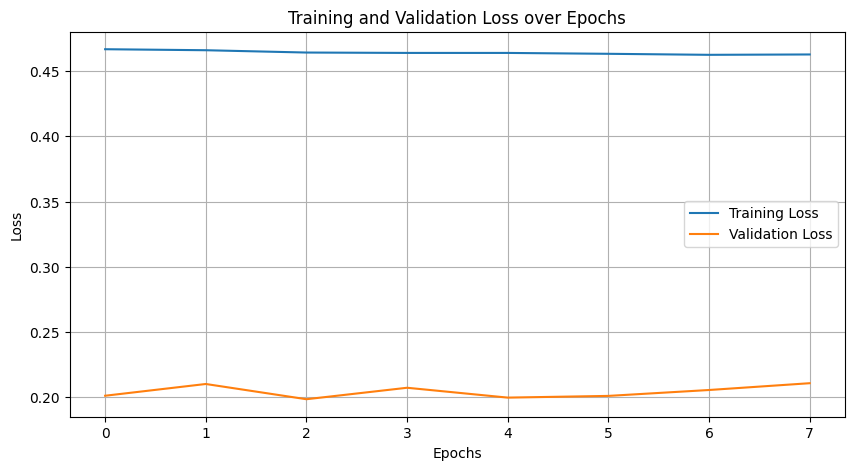

In [ ]:
# Plot training and validation loss
def plot_loss(training_losses, validation_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(training_losses, validation_losses)


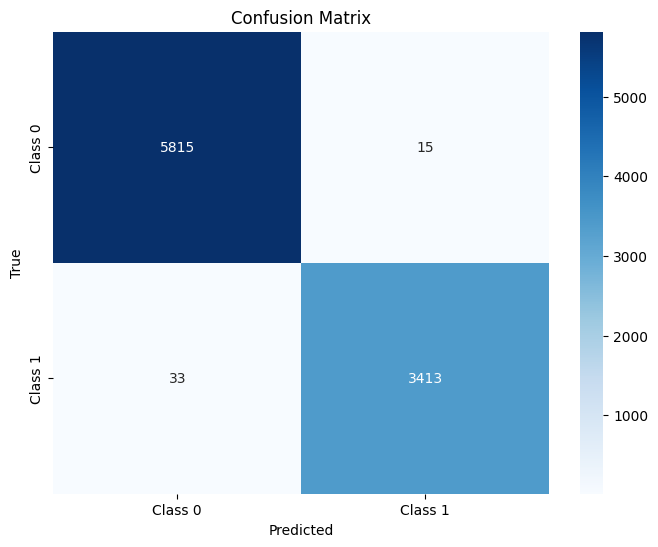

In [ ]:
# Plotting confusion matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix)


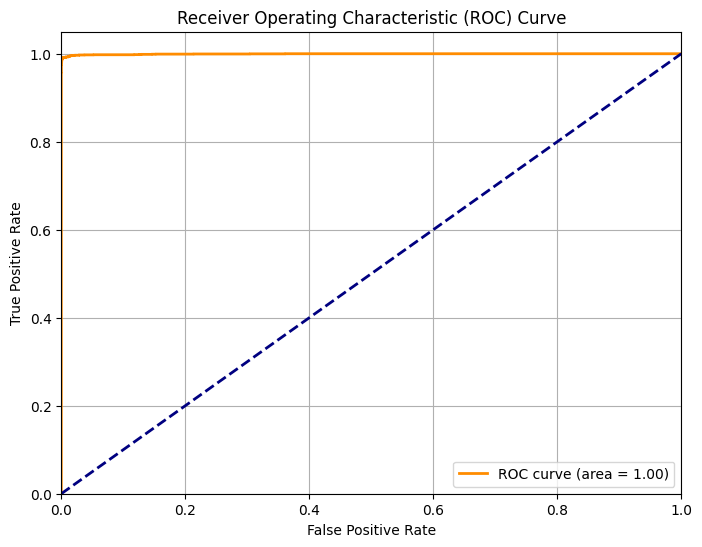

In [ ]:
# Plotting ROC curve
def plot_roc_curve(all_labels, all_pred_probs):
    fpr, tpr, _ = roc_curve(all_labels, all_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_roc_curve(all_labels, all_pred_probs)


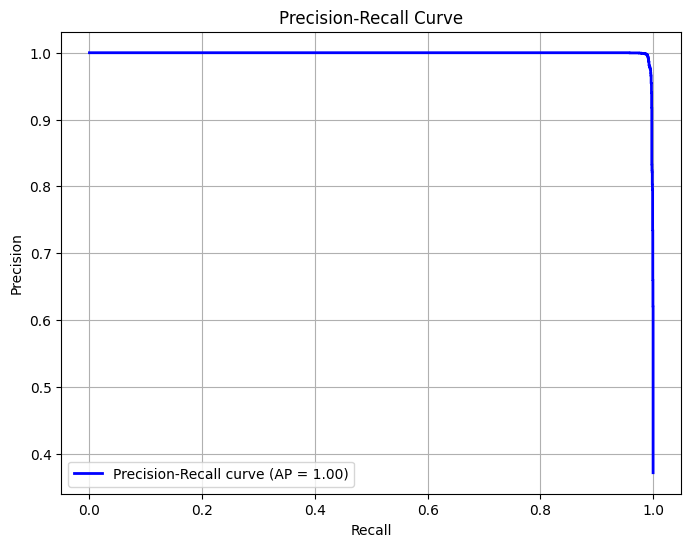

In [ ]:
# Plotting precision-recall curve
def plot_precision_recall_curve(all_labels, all_pred_probs):
    precision, recall, _ = precision_recall_curve(all_labels, all_pred_probs)
    average_precision = average_precision_score(all_labels, all_pred_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

plot_precision_recall_curve(all_labels, all_pred_probs)  # Use predicted probabilities for precision-recall curve


Number of False Positives: 15
Number of False Negatives: 33


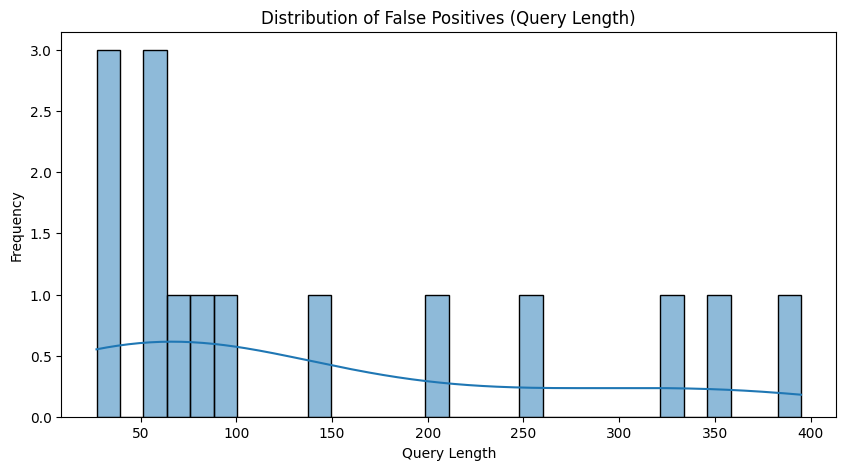

In [ ]:
# False Positives and Negatives Analysis
false_positives = (all_preds == 1) & (all_labels == 0)
false_negatives = (all_preds == 0) & (all_labels == 1)

print(f'Number of False Positives: {false_positives.sum()}')
print(f'Number of False Negatives: {false_negatives.sum()}')

# Identify the indices of false positives and false negatives
false_positive_indices = np.where(false_positives)[0]
false_negative_indices = np.where(false_negatives)[0]

# Filter the DataFrame for false positives and negatives using these indices
df_false_positives = df_no_outliers.iloc[false_positive_indices]
df_false_negatives = df_no_outliers.iloc[false_negative_indices]

# Plot False Positives
plt.figure(figsize=(10, 5))
sns.histplot(df_false_positives['Query'].apply(len), bins=30, kde=True)
plt.title('Distribution of False Positives (Query Length)')
plt.xlabel('Query Length')
plt.ylabel('Frequency')
plt.show()

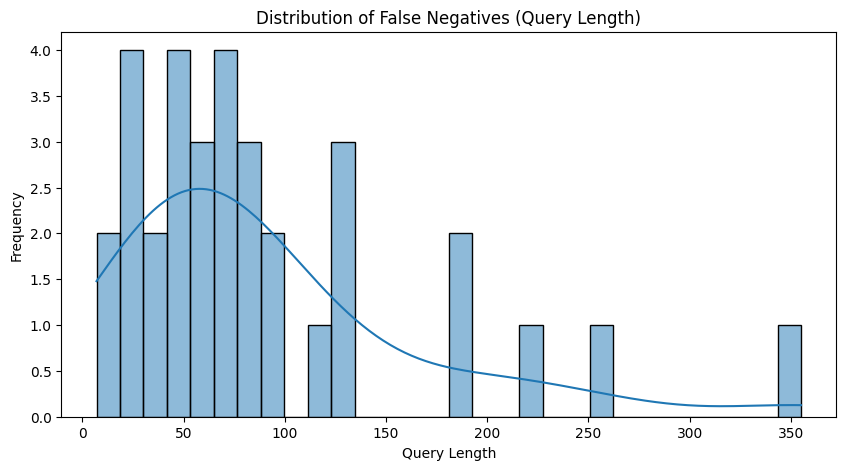

In [ ]:
# Plot False Negatives
plt.figure(figsize=(10, 5))
sns.histplot(df_false_negatives['Query'].apply(len), bins=30, kde=True)
plt.title('Distribution of False Negatives (Query Length)')
plt.xlabel('Query Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
false_positive_queries = df_no_outliers.iloc[false_positives].reset_index()
false_negative_queries = df_no_outliers.iloc[false_negatives].reset_index()


In [ ]:
def extract_patterns(queries):
    patterns = []
    for query in queries['Query']:
        tokens = query.split()
        patterns.extend(tokens)
    return Counter(patterns).most_common(10)

false_positive_patterns = extract_patterns(false_positive_queries)
false_negative_patterns = extract_patterns(false_negative_queries)

print("Common patterns in false positives:", false_positive_patterns)
print("Common patterns in false negatives:", false_negative_patterns)


Common patterns in false positives: [('"', 9261), ('or', 9261), ('pg_sleep', 9261), ('(', 9261), ('__time__', 9261), (')', 9261), ('--', 9261), ('tablespace', 30), ('create', 15), ('user', 15)]
Common patterns in false negatives: [('"', 9243), ('or', 9243), ('pg_sleep', 9243), ('(', 9243), ('__time__', 9243), (')', 9243), ('--', 9243), ('tablespace', 66), ('create', 33), ('user', 33)]


In [ ]:
def analyze_queries(queries):
    analysis = []
    for index, row in queries.iterrows():
        query = row['Query']
        complexity = len(query.split())
        analysis.append({
            'Query': query,
            'Complexity': complexity,
            'Length': len(query)
        })
    return pd.DataFrame(analysis)

false_positive_analysis = analyze_queries(false_positive_queries)
false_negative_analysis = analyze_queries(false_negative_queries)

false_positive_analysis.head()
false_negative_analysis.head()


,Query,Complexity,Length
0,""" or pg_sleep ( __time__ ) --",7,33
1,""" or pg_sleep ( __time__ ) --",7,33
2,""" or pg_sleep ( __time__ ) --",7,33
3,""" or pg_sleep ( __time__ ) --",7,33
4,""" or pg_sleep ( __time__ ) --",7,33


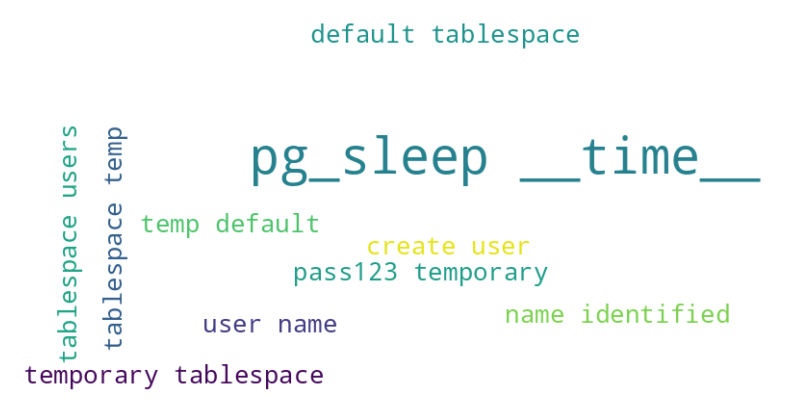

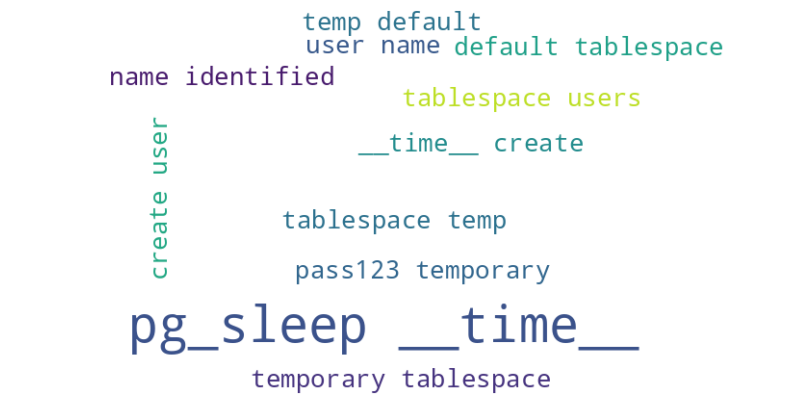

In [ ]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Concatenate all queries into a single string for word cloud generation
false_positive_text = ' '.join(false_positive_queries['Query'])
false_negative_text = ' '.join(false_negative_queries['Query'])

generate_wordcloud(false_positive_text)
generate_wordcloud(false_negative_text)


 Performing a Sensitivity Analysis for BERT-GNN

In [ ]:
# Function to perform sensitivity analysis on a model by perturbing the graphs in a dataset
def sensitivity_analysis(model, data_loader, perturbation_type="remove", perturb_fraction=0.1):
    # List to store sensitivity scores for each graph
    sensitivity_scores = []

    print("Starting sensitivity analysis...")
    sys.stdout.flush()

    # Determine the device to run the model on (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Move the model to the chosen device
    model.to(device)
    print(f"Model is on device: {device}")
    print(f"Data loader has {len(data_loader)} batches.")
    sys.stdout.flush()

    # Check if the data loader is empty
    if len(data_loader) == 0:
        print("Data loader is empty.")
        sys.stdout.flush()
        return

    # Iterate over each graph in the data loader
    for i, data in enumerate(data_loader):
        try:
            print(f"Processing graph {i}...")
            sys.stdout.flush()

            # Move the data (graph) to the device
            data = data.to(device)
            x = data.x  # Node features
            edge_index = data.edge_index  # Edge indices
            batch = data.batch  # Batch vector

            # Display the shape of the current graph's components
            print(f"Graph {i} - x.shape: {x.shape}, edge_index.shape: {edge_index.shape}, batch.shape: {batch.shape}")
            sys.stdout.flush()

            # Set the model to evaluation mode (important to disable dropout, etc.)
            model.eval()
            # Perform a forward pass to get the model's original predictions on the graph
            with torch.no_grad():
                original_preds = model(x, edge_index, batch)

            # Display the shape of the original predictions
            print(f"Original predictions for graph {i} obtained with shape: {original_preds.shape}")
            sys.stdout.flush()

            # Perturb the graph by removing a fraction of its nodes or edges
            perturbed_data = perturb_graph(data, perturbation_type, perturb_fraction)

            # If the perturbation fails, skip this graph
            if perturbed_data is None:
                print(f"Perturbation failed for graph {i}. Skipping...")
                sys.stdout.flush()
                continue

            # Extract the perturbed graph's components
            perturbed_x = perturbed_data.x
            perturbed_edge_index = perturbed_data.edge_index
            perturbed_batch = perturbed_data.batch

            # Display the shape of the perturbed graph's components
            print(f"Graph {i} after perturbation - x.shape: {perturbed_x.shape}, edge_index.shape: {perturbed_edge_index.shape}, batch.shape: {perturbed_batch.shape}")
            sys.stdout.flush()

            # Perform a forward pass on the perturbed graph to get the model's predictions
            with torch.no_grad():
                perturbed_preds = model(perturbed_x, perturbed_edge_index, perturbed_batch)

            # Display the shape of the perturbed predictions
            print(f"Perturbed predictions for graph {i} obtained with shape: {perturbed_preds.shape}")
            sys.stdout.flush()

            # Ensure the predictions have the same length by truncating to the shortest
            min_length = min(original_preds.size(0), perturbed_preds.size(0))
            original_preds = original_preds[:min_length]
            perturbed_preds = perturbed_preds[:min_length]

            # Calculate the sensitivity as the mean absolute difference between original and perturbed predictions
            sensitivity = torch.abs(original_preds - perturbed_preds).mean().item()
            # Store the sensitivity score for this graph
            sensitivity_scores.append(sensitivity)

            # Display the sensitivity score for the current graph
            print(f"Sensitivity Score for graph {i}: {sensitivity:.4f}")
            sys.stdout.flush()
        except Exception as e:
            # If an error occurs during processing, print it and continue with the next graph
            print(f"Error processing graph {i}: {e}")
            sys.stdout.flush()
            continue

    # Calculate the average sensitivity score across all processed graphs
    average_sensitivity = sum(sensitivity_scores) / len(sensitivity_scores) if sensitivity_scores else 0
    print(f"Average Sensitivity Score: {average_sensitivity:.4f}")

    # Return the list of sensitivity scores
    return sensitivity_scores


In [ ]:
# Perform sensitivity analysis on the model using the test data loader and store the resulting sensitivity scores
sensitivity_scores = sensitivity_analysis(model_cpu, test_loader)


Starting sensitivity analysis...
Model is on device: cuda
Data loader has 99 batches.
Processing graph 0...
Graph 0 - x.shape: torch.Size([1139, 768]), edge_index.shape: torch.Size([2, 1045]), batch.shape: torch.Size([1139])
Original predictions for graph 0 obtained with shape: torch.Size([94, 2])
Graph 0 after perturbation - x.shape: torch.Size([1026, 768]), edge_index.shape: torch.Size([2, 839]), batch.shape: torch.Size([1026])
Perturbed predictions for graph 0 obtained with shape: torch.Size([94, 2])
Sensitivity Score for graph 0: 0.0387
Processing graph 1...
Graph 1 - x.shape: torch.Size([1136, 768]), edge_index.shape: torch.Size([2, 1042]), batch.shape: torch.Size([1136])
Original predictions for graph 1 obtained with shape: torch.Size([94, 2])
Graph 1 after perturbation - x.shape: torch.Size([1023, 768]), edge_index.shape: torch.Size([2, 842]), batch.shape: torch.Size([1023])
Perturbed predictions for graph 1 obtained with shape: torch.Size([94, 2])
Sensitivity Score for graph 1:

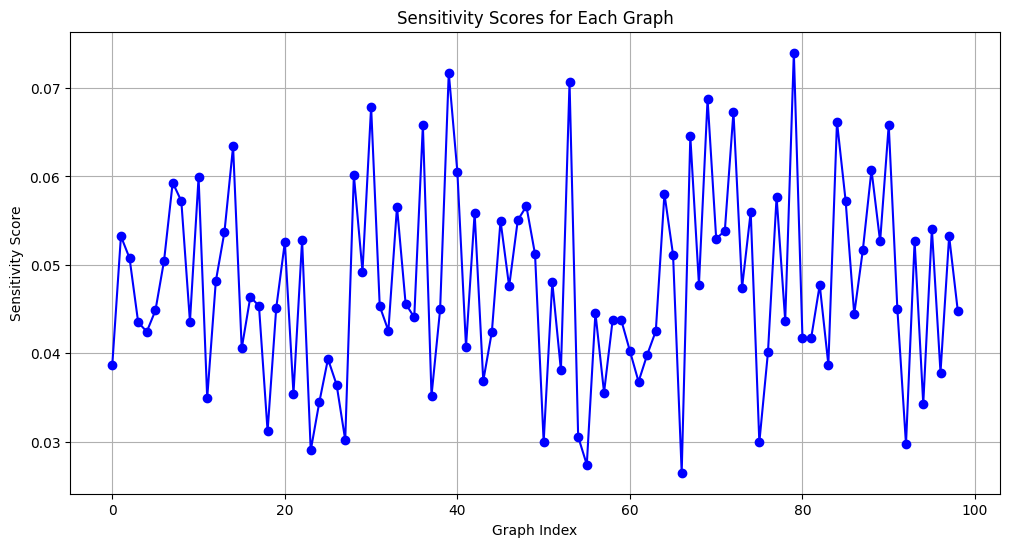

In [ ]:
# Plot the sensitivity scores
plt.figure(figsize=(12, 6))
plt.plot(sensitivity_scores, marker='o', linestyle='-', color='blue')
plt.title('Sensitivity Scores for Each Graph')
plt.xlabel('Graph Index')
plt.ylabel('Sensitivity Score')
plt.grid(True)
plt.show()


Training Machine learning and Ensemble classifiers on Sql injection to Benchmark BERT-GNN and DistilBERT Meta Ensemble

In [ ]:
!pip install imbalanced-learn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler

In [ ]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Load the original dataset
data = pd.read_csv('SQL_Injection_Dataset.csv')


In [ ]:
# Initialize the lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a function for text preprocessing
def preprocess_text(text):
    # Normalize text (convert to lowercase)
    text = text.lower()

    # Remove non-alphanumeric characters except for SQL-related characters
    text = re.sub(r'[^\w\s;\'\"=]', ' ', text)

    # Tokenize text
    words = text.split()

    # Define SQL keywords to be retained
    sql_keywords = {'select', 'from', 'where', 'insert', 'update', 'delete', 'join', 'on', 'create', 'table', 'drop', 'alter', 'add', 'and', 'or', 'not', 'null', 'like', 'in', 'between'}

    # Remove stop words while retaining SQL keywords
    words = [word for word in words if word not in stop_words or word in sql_keywords]

    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join words back into a single string
    preprocessed_text = ' '.join(words)
    return preprocessed_text

# Apply preprocessing to the DataFrame
data['Query'] = data['Query'].apply(preprocess_text)
print(data.head())



                                               Query  Label
0                             " or pg_sleep __time__      1
1  create user name identified pass123 temporary ...      1
2  and 1 = utl_inaddr get_host_address select dis...      1
3  select from user where id = '1' or 1 = 1 union...      1
4  select from user where id = 1 or 1 " union sel...      1


In [ ]:
# Preprocess the data
data['Query'] = data['Query'].apply(lambda x: str(x).lower().strip())

In [ ]:
# Split the data into training and test sets
X = data['Query']
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Transform the data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_tfidf_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

In [ ]:
# Define classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear'),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boost': GradientBoostingClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [ ]:
# Cross-validation and timing
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
train_times = {}
execution_times = {}

for name, clf in classifiers.items():
    print(f"Training {name}...")
    start_time = time.time()
    cv_scores = cross_val_score(clf, X_train_tfidf_res, y_train_res, cv=cv, scoring='accuracy')
    train_time = time.time() - start_time

    start_time = time.time()
    clf.fit(X_train_tfidf_res, y_train_res)
    train_time = time.time() - start_time

    start_time = time.time()
    y_pred = clf.predict(X_test_tfidf)
    execution_time = time.time() - start_time

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': classification_report(y_test, y_pred, target_names=['Benign', 'Malicious'], output_dict=True),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'cv_scores': cv_scores,
        'y_pred': y_pred
    }
    train_times[name] = train_time
    execution_times[name] = execution_time

# Visualize the results
for name, result in results.items():
    print(f"Classifier: {name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1 Score: {result['f1_score']:.4f}")
    print("Classification Report:\n", classification_report(y_test, result['y_pred'], target_names=['Benign', 'Malicious']))
    print("Confusion Matrix:\n", result['confusion_matrix'])
    print("Cross-Validation Scores:", result['cv_scores'])
    print("Average Cross-Validation Score:", np.mean(result['cv_scores']))
    print("Training Time:", train_times[name])
    print("Execution Time:", execution_times[name])
    print("\n")


Training Decision Tree...
Training Logistic Regression...
Training SVM...
Training Naive Bayes...
Training Random Forest...
Training Gradient Boost...
Training XGBoost...
Classifier: Decision Tree
Accuracy: 0.9918
Precision: 0.9918
Recall: 0.9918
F1 Score: 0.9918
Classification Report:
               precision    recall  f1-score   support

      Benign       0.99      0.99      0.99      3908
   Malicious       0.99      0.99      0.99      2276

    accuracy                           0.99      6184
   macro avg       0.99      0.99      0.99      6184
weighted avg       0.99      0.99      0.99      6184

Confusion Matrix:
 [[3886   22]
 [  29 2247]]
Cross-Validation Scores: [0.99168266 0.99360205 0.99024312 0.98992161 0.99168133]
Average Cross-Validation Score: 0.991426154924617
Training Time: 0.5183453559875488
Execution Time: 0.004499673843383789


Classifier: Logistic Regression
Accuracy: 0.9882
Precision: 0.9882
Recall: 0.9882
F1 Score: 0.9882
Classification Report:
            

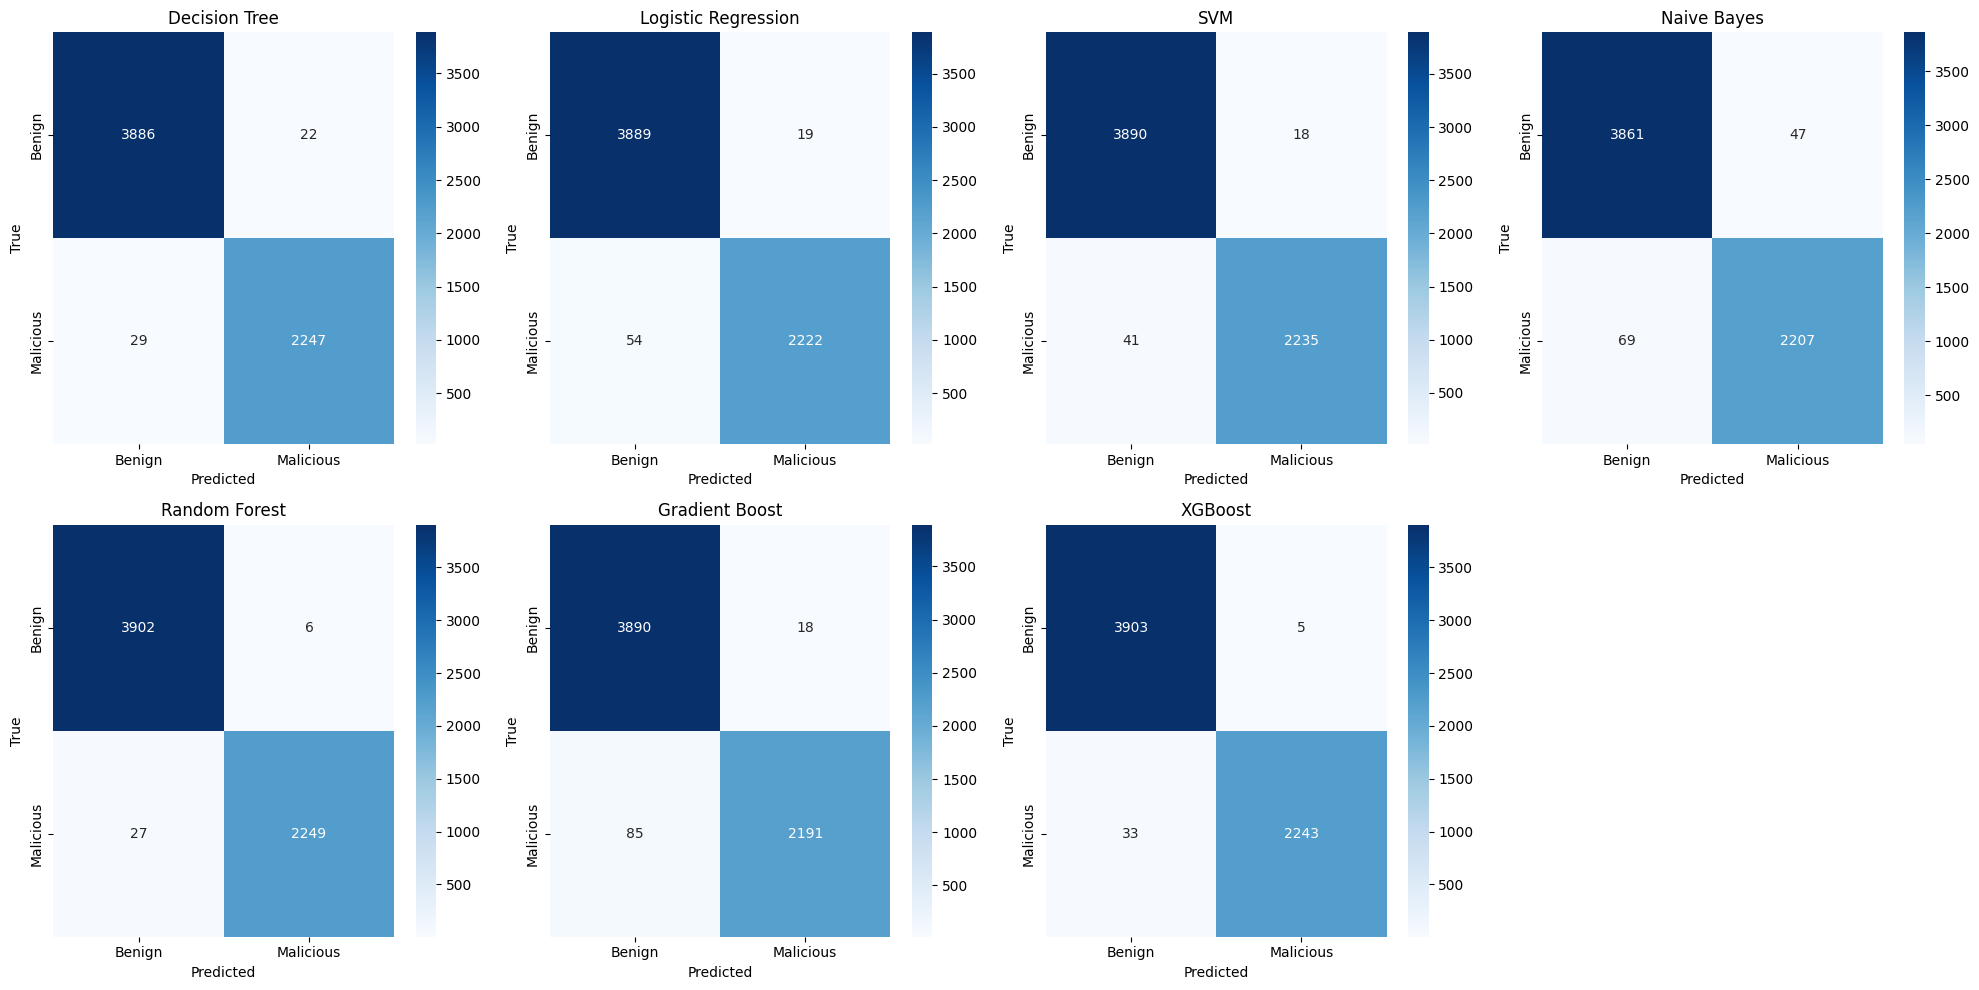

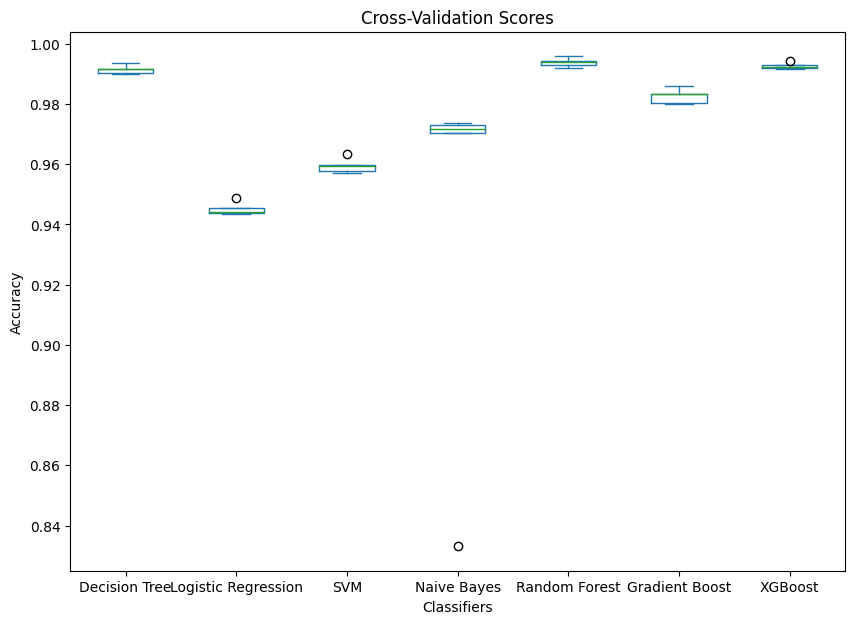

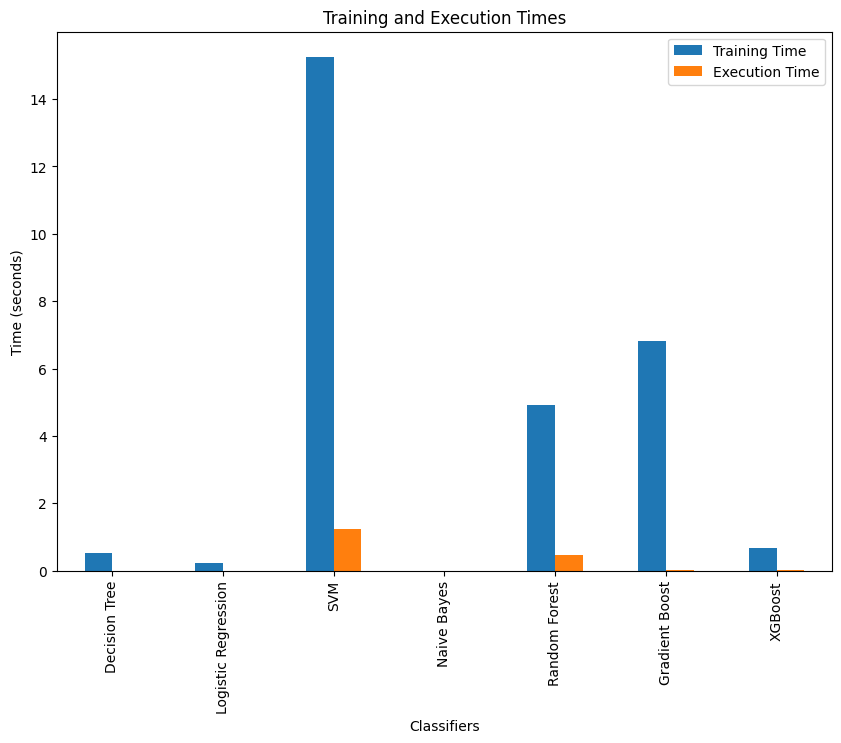

In [ ]:
# Plotting confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for ax, (name, result) in zip(axes, results.items()):
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'], ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

# Remove the last empty subplot
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

# Plotting cross-validation scores
cv_scores_df = pd.DataFrame({name: result['cv_scores'] for name, result in results.items()})
cv_scores_df.plot(kind='box', figsize=(10, 7))
plt.title('Cross-Validation Scores')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()

# Plotting training and execution times
times_df = pd.DataFrame({'Training Time': train_times, 'Execution Time': execution_times})
times_df.plot(kind='bar', figsize=(10, 7))
plt.title('Training and Execution Times')
plt.xlabel('Classifiers')
plt.ylabel('Time (seconds)')
plt.show()


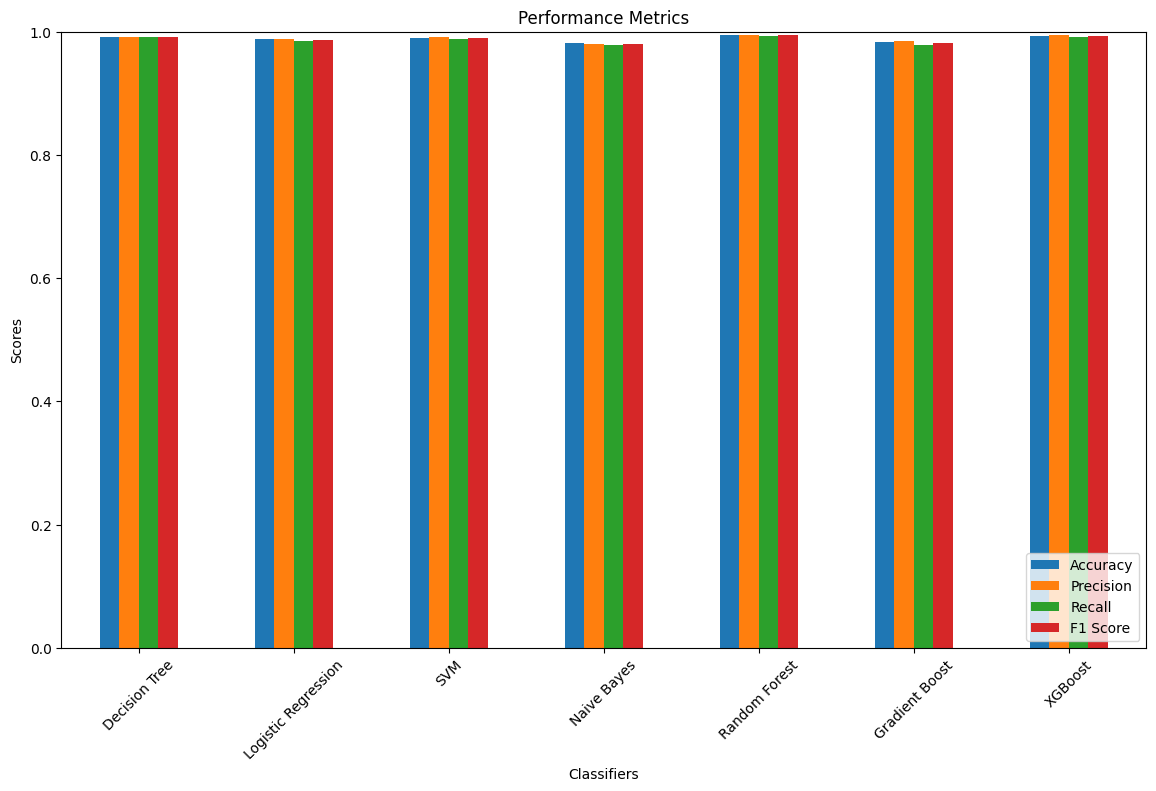

In [ ]:
# Extracting performance metrics for visualization
accuracies = []
precisions = []
recalls = []
f1_scores = []

for result in results.values():
    accuracies.append(result['accuracy'])
    precisions.append(result['classification_report']['macro avg']['precision'])
    recalls.append(result['classification_report']['macro avg']['recall'])
    f1_scores.append(result['classification_report']['macro avg']['f1-score'])

# Creating a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Classifier': list(results.keys()),
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

# Plotting the performance metrics
metrics_df.set_index('Classifier').plot(kind='bar', figsize=(14, 8))
plt.title('Performance Metrics')
plt.xlabel('Classifiers')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()